In [359]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import missingno as mo
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split

In [360]:
df=pd.read_csv('data_from_MRI.csv')

In [361]:
df.head()

,ID,acc_itn,priority,acct,stp_dtime,ord_for_dtime,dept,proc_no,reason1,cpt_code,pt_adm_no_ext
0,1,7231535,Routine,4004017060,12-04-2017 17:11,12-04-2017 01:56,MRI,1601,lip abscess,70543.0,4004017060
1,2,7231655,Routine,4004017134,13-04-2017 17:20,12-04-2017 08:06,MRI,1602,large sacral decubitus,72197.0,4004017134
2,3,7231760,Routine,6223112189,12-04-2017 22:07,12-04-2017 09:26,MRI,1604,panc abnormality,74183.0,6223112189
3,4,7231762,Routine,6223112302,12-04-2017 16:16,12-04-2017 09:32,MRI,1554,rule out CNS mets,70553.0,6223112302
4,5,7231812,Routine,6223108688,12-04-2017 21:52,12-04-2017 09:59,MRI,447,Syncope/dizziness,70551.0,6223108688


In [362]:
df.columns

Index(['ID', 'acc_itn', 'priority', 'acct', 'stp_dtime', 'ord_for_dtime',
       'dept', 'proc_no', 'reason1', 'cpt_code', 'pt_adm_no_ext'],
      dtype='object')

In [363]:
# 4755 rows and 11 columns
df.shape

(4755, 11)

ID and acc_itn columns don't add any value to the target variable. time columns are objects so should be converted to datetime 

In [364]:
# Info about columns. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4755 entries, 0 to 4754
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             4755 non-null   int64  
 1   acc_itn        4755 non-null   int64  
 2   priority       4755 non-null   object 
 3   acct           4755 non-null   int64  
 4   stp_dtime      4755 non-null   object 
 5   ord_for_dtime  4755 non-null   object 
 6   dept           4755 non-null   object 
 7   proc_no        4755 non-null   int64  
 8   reason1        4337 non-null   object 
 9   cpt_code       4751 non-null   float64
 10  pt_adm_no_ext  4755 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 408.8+ KB


In [365]:
#Statistics about the data

df.describe()

,ID,acc_itn,acct,proc_no,cpt_code,pt_adm_no_ext
count,4755.000000,4.755000e+03,4.755000e+03,4755.000000,4751.00000,4.755000e+03
mean,2378.000000,7.419800e+06,5.598179e+09,1020.975394,71489.08314,5.598179e+09
std,1372.794595,1.100040e+05,9.908031e+08,575.678701,1381.36143,9.908031e+08
min,1.000000,7.231535e+06,3.100000e+09,446.000000,70540.00000,3.100000e+09
25%,1189.500000,7.325926e+06,4.004063e+09,447.000000,70551.00000,4.004063e+09
50%,2378.000000,7.416011e+06,6.223232e+09,455.000000,70551.00000,6.223232e+09
75%,3566.500000,7.514258e+06,6.223383e+09,1602.000000,72156.00000,6.223383e+09
max,4755.000000,7.617326e+06,6.223548e+09,1675.000000,75561.00000,6.223548e+09


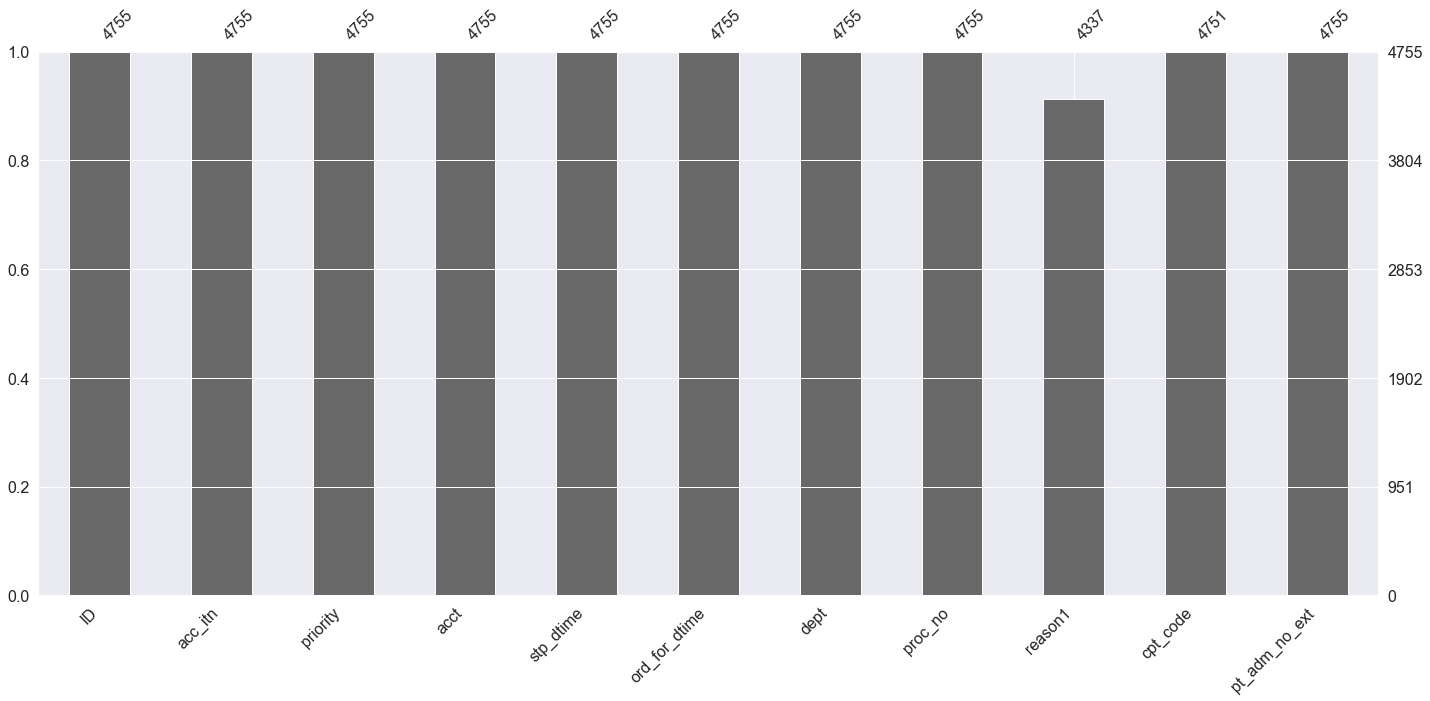

In [366]:
mo.bar(df)

In [370]:
df['priority'] = df['priority'].replace(['Routine ','ROUTINE '],'Routine')
df['priority'] = df['priority'].replace(['As soon ','ASAP    ','As soon','ASAP'],'ASAP')
df['priority'] = df['priority'].replace(['Stat    ','STAT    '],'STAT')
df['priority'] = df['priority'].replace(['SCHEDULE','Schedule'],'Schedule')
df['priority'] = df['priority'].replace(['PRIOR 1 ','PRTY 1  '],'Priority')
df['priority'] = df['priority'].replace(['Neuro   '],'Neuro')

In [371]:
df['priority'].value_counts()

Routine     3351
STAT         477
ASAP         453
Schedule     353
Priority     119
Neuro          2
Name: priority, dtype: int64

In [372]:
# Null values check
df.isnull().sum()

ID                 0
acc_itn            0
priority           0
acct               0
stp_dtime          0
ord_for_dtime      0
dept               0
proc_no            0
reason1          418
cpt_code           4
pt_adm_no_ext      0
dtype: int64

In [373]:
#data types of every column
df.dtypes

ID                 int64
acc_itn            int64
priority          object
acct               int64
stp_dtime         object
ord_for_dtime     object
dept              object
proc_no            int64
reason1           object
cpt_code         float64
pt_adm_no_ext      int64
dtype: object

reason1 column contains textual data and all are different hence doesn't add any value

In [374]:

df.reason1.value_counts()

TIA                                         573
Stroke                                      572
Altered Level of Consciousness              222
Dizziness                                   170
Syncope                                     115
                                           ... 
Myocardial Infarction, 3v CAD                 1
bilateral hand tingling                       1
mrcp - cholangioca with increasing lfts/      1
R heel decub ulcer; ? osteomyelitis           1
left foot ulcer, r/o osteomyelitis            1
Name: reason1, Length: 1423, dtype: int64

Most widely used cpt code is 70551. We will Nan values with this

In [378]:
# most widely used cpt code
df.cpt_code.mode()

0    70551.0
dtype: float64

In [379]:
def mko(df):
    mis_no = df.isnull().sum()/len(df) *100
    c=df.isnull().sum()
    miss_frame=pd.concat([c,mis_no],axis=1)
    renamecol=miss_frame.rename(columns={0:"Count",1:"Percentage"})
    renamecol=renamecol[renamecol["Count"]!=0]
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(renamecol.shape[0]) +
              " columns that have missing values.")
    return renamecol.round(4)

In [380]:
 mko(df)

Your selected dataframe has 11 columns.
There are 2 columns that have missing values.


,Count,Percentage
reason1,418,8.7907
cpt_code,4,0.0841


We are dropping 'reason1', 'ID', and 'acc_itn' because they don't add any value to the target variable

In [381]:
# Dropping 
df.drop(columns=['reason1','ID', 'acc_itn'],axis=1,inplace=True)

In [382]:
df.columns

Index(['priority', 'acct', 'stp_dtime', 'ord_for_dtime', 'dept', 'proc_no',
       'cpt_code', 'pt_adm_no_ext'],
      dtype='object')

Filling cpt_code with its mode because it's a categorial column

In [383]:
df['cpt_code']=df['cpt_code'].fillna(df['cpt_code'].mode()[0])

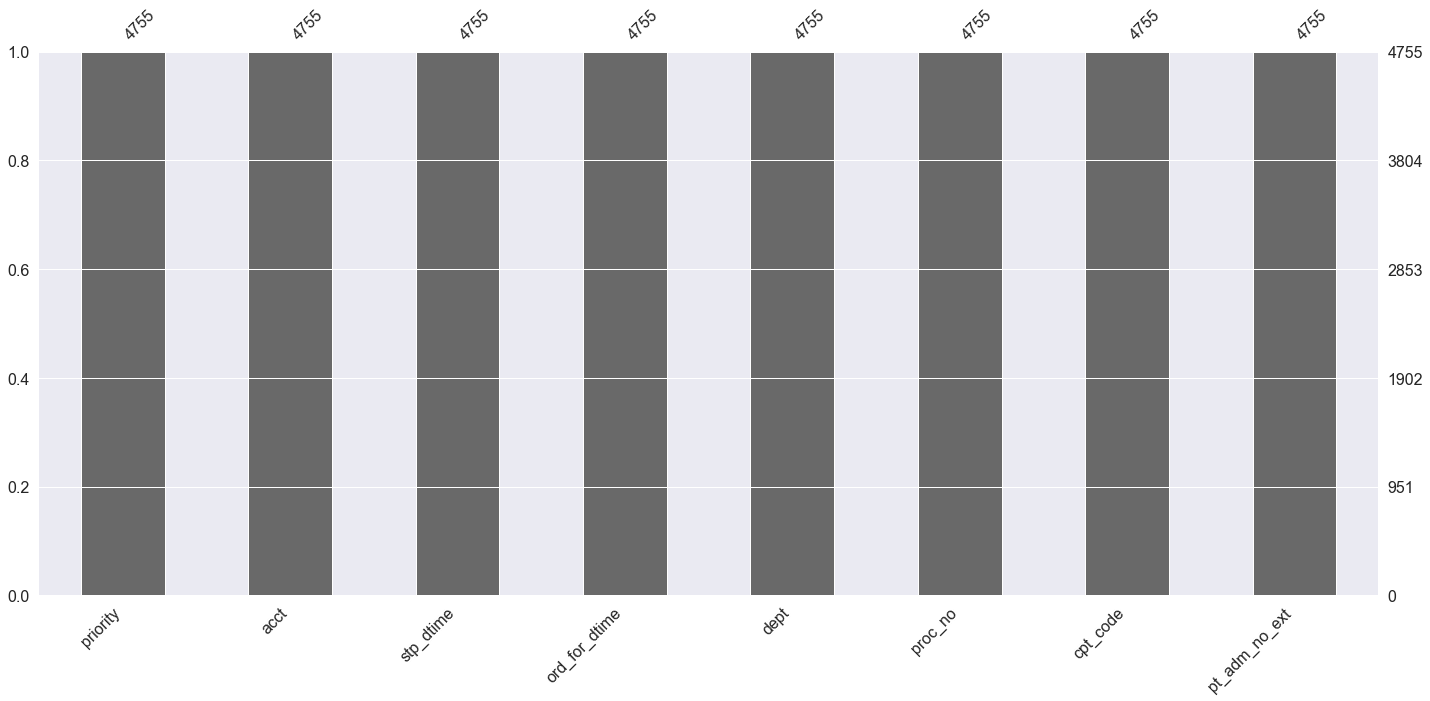

In [384]:
mo.bar(df)

NO NULL Values NOW

In [386]:
mko(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Count,Percentage


In [387]:
df.head()

,priority,acct,stp_dtime,ord_for_dtime,dept,proc_no,cpt_code,pt_adm_no_ext
0,Routine,4004017060,12-04-2017 17:11,12-04-2017 01:56,MRI,1601,70543.0,4004017060
1,Routine,4004017134,13-04-2017 17:20,12-04-2017 08:06,MRI,1602,72197.0,4004017134
2,Routine,6223112189,12-04-2017 22:07,12-04-2017 09:26,MRI,1604,74183.0,6223112189
3,Routine,6223112302,12-04-2017 16:16,12-04-2017 09:32,MRI,1554,70553.0,6223112302
4,Routine,6223108688,12-04-2017 21:52,12-04-2017 09:59,MRI,447,70551.0,6223108688


In [388]:
df.priority.value_counts()

Routine     3351
STAT         477
ASAP         453
Schedule     353
Priority     119
Neuro          2
Name: priority, dtype: int64

We are converting datetime columns to datetime type because they are in object type

In [389]:
import datetime

df['ord_for_dtime'] =  pd.to_datetime(df['ord_for_dtime'] )
df['stp_dtime'] =  pd.to_datetime(df['stp_dtime'] )

In [390]:
df.head()

,priority,acct,stp_dtime,ord_for_dtime,dept,proc_no,cpt_code,pt_adm_no_ext
0,Routine,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,MRI,1601,70543.0,4004017060
1,Routine,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,MRI,1602,72197.0,4004017134
2,Routine,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,MRI,1604,74183.0,6223112189
3,Routine,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,MRI,1554,70553.0,6223112302
4,Routine,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,MRI,447,70551.0,6223108688


In [391]:
df.dtypes

priority                 object
acct                      int64
stp_dtime        datetime64[ns]
ord_for_dtime    datetime64[ns]
dept                     object
proc_no                   int64
cpt_code                float64
pt_adm_no_ext             int64
dtype: object

We are taking different to make a new column named 'duration' and changing its type to timedelta

In [392]:
df['duration']=(df.stp_dtime-df.ord_for_dtime).astype('timedelta64[m]')

In [393]:
df.head()

,priority,acct,stp_dtime,ord_for_dtime,dept,proc_no,cpt_code,pt_adm_no_ext,duration
0,Routine,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,MRI,1601,70543.0,4004017060,915.0
1,Routine,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,MRI,1602,72197.0,4004017134,-337846.0
2,Routine,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,MRI,1604,74183.0,6223112189,761.0
3,Routine,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,MRI,1554,70553.0,6223112302,404.0
4,Routine,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,MRI,447,70551.0,6223108688,713.0


In [394]:
# Handling negative durations
df['duration']=abs(df['duration'])

In [395]:
df.head()

,priority,acct,stp_dtime,ord_for_dtime,dept,proc_no,cpt_code,pt_adm_no_ext,duration
0,Routine,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,MRI,1601,70543.0,4004017060,915.0
1,Routine,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,MRI,1602,72197.0,4004017134,337846.0
2,Routine,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,MRI,1604,74183.0,6223112189,761.0
3,Routine,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,MRI,1554,70553.0,6223112302,404.0
4,Routine,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,MRI,447,70551.0,6223108688,713.0


In [396]:
import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['priority'],
	df['duration'],
], axis=1)
chart_data = chart_data.sort_values(['priority'])
chart_data = chart_data.rename(columns={'priority': 'x'})
chart_data = chart_data.groupby(['x'])[['duration']].mean().reset_index()
chart_data = chart_data.dropna()

import plotly.graph_objs as go

charts = []
charts.append(go.Bar(
x=chart_data['x'],
y=chart_data['duration']
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'duration by priority (Mean) in Minutes'},
    'xaxis': {'title': {'text': 'priority'}},
    'yaxis': {'title': {'text': 'duration (Minutes)'}}
}))

# Plot of Avg duration by priority of the procedure

In [397]:
figure

# •	Avg duration by priority of the procedure

In [398]:
avg_duration_by_priority = df.groupby('priority')['duration'].mean().reset_index()
avg_duration_by_priority.columns = ['priority', 'avg_duration']
avg_duration_by_priority

,priority,avg_duration
0,ASAP,17537.028698
1,Neuro,740.500000
2,Priority,1218.327731
3,Routine,23578.403760
4,STAT,8974.683438
5,Schedule,14828.838527


# No of scans by priority of the procedure

In [399]:
no_of_scans_by_priority = df['priority'].value_counts().reset_index()
no_of_scans_by_priority.columns = ['priority', 'no_of_scans']
no_of_scans_by_priority

,priority,no_of_scans
0,Routine,3351
1,STAT,477
2,ASAP,453
3,Schedule,353
4,Priority,119
5,Neuro,2


# Avg Duration & Total Scans by Priority

In [400]:
avg_duration_by_priority['no_of_scans'] = no_of_scans_by_priority['no_of_scans']
avg_duration_by_priority

,priority,avg_duration,no_of_scans
0,ASAP,17537.028698,3351
1,Neuro,740.500000,477
2,Priority,1218.327731,453
3,Routine,23578.403760,353
4,STAT,8974.683438,119
5,Schedule,14828.838527,2


In [401]:
#for pyacart
df.to_csv('newmri.csv')

# Insight on correlation with pairplot

We are ploting pairplot of the numerical columns to see relationships. We can notice that there isn't any good relationship of any variable to target variable which is sad thing for a regression problem, but the best thing for classification problem. The insight is that regression model may not bring good results but classification model will bring best results

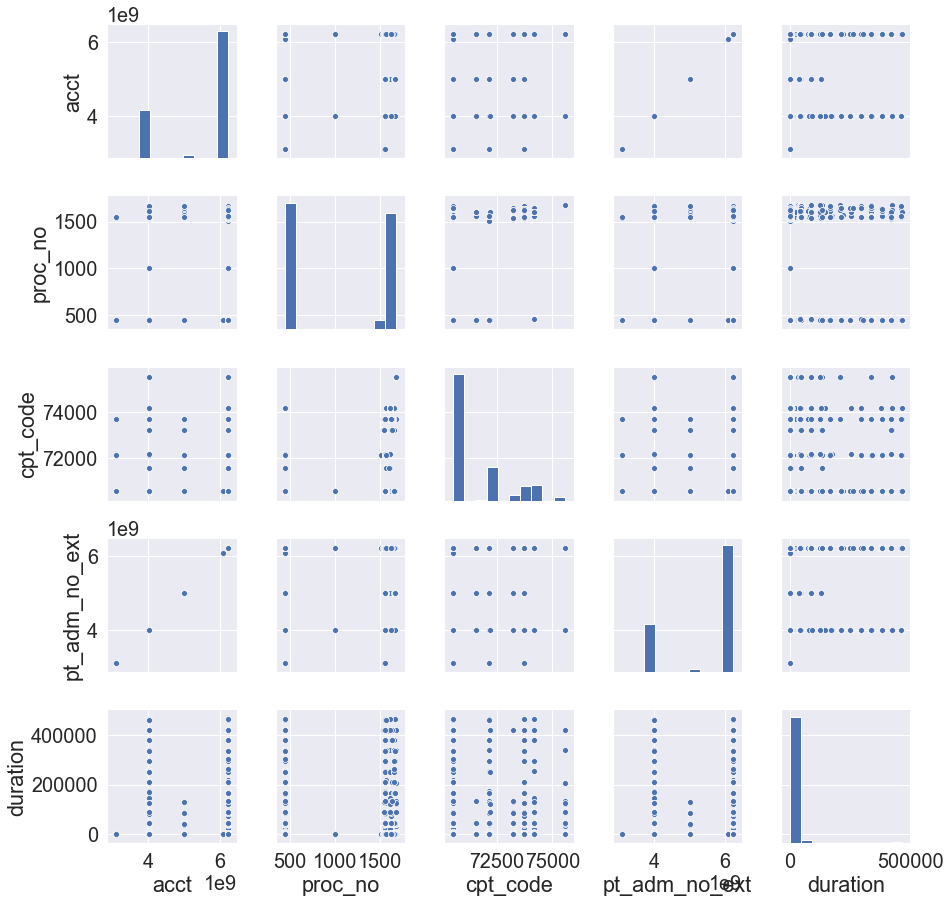

In [402]:
# Ploting pairplot of the numerical columns to see relationships.
sb.pairplot(df)

In [403]:
df.dtypes

priority                 object
acct                      int64
stp_dtime        datetime64[ns]
ord_for_dtime    datetime64[ns]
dept                     object
proc_no                   int64
cpt_code                float64
pt_adm_no_ext             int64
duration                float64
dtype: object

# Insight on correlation with its values

The greater the correlation with our target variable 'duration', the better it is for our model. We can see the chart, there is no good relationship of any variable with our target variable. It's really not good for our regression problem, but we will be happy with our classification model as the data is spread out very well

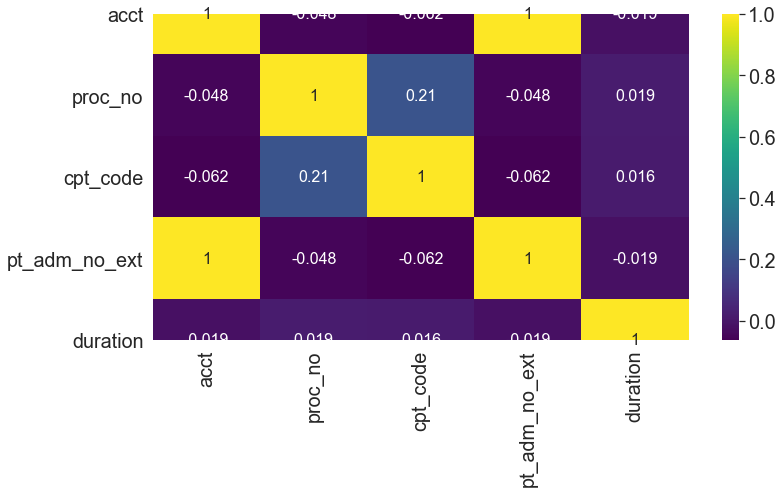

In [404]:
# Finding correlation between the columns

corr_mat = df.corr()
sb.set(font_scale=1.8)
plt.figure(figsize=(12,6))
sb.heatmap(corr_mat, annot=True, cmap='viridis' , annot_kws={"size": 16},)

# Encoding categorical variables

We have two category columns so we are encoding them

In [412]:
cat_col=df.select_dtypes(include=[np.object])
cat_col.columns

Index(['priority', 'dept'], dtype='object')

In [413]:
zebra=['priority', 'dept']

In [414]:
dummies=pd.get_dummies(df,columns=zebra,drop_first=True)
dummies.shape

(4755, 12)

In [415]:
dummies.head()

,acct,stp_dtime,ord_for_dtime,proc_no,cpt_code,pt_adm_no_ext,duration,priority_Neuro,priority_Priority,priority_Routine,priority_STAT,priority_Schedule
0,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,1601,70543.0,4004017060,915.0,0,0,1,0,0
1,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,1602,72197.0,4004017134,337846.0,0,0,1,0,0
2,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,1604,74183.0,6223112189,761.0,0,0,1,0,0
3,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,1554,70553.0,6223112302,404.0,0,0,1,0,0
4,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,447,70551.0,6223108688,713.0,0,0,1,0,0


Our cpt_code is a category column so we are converting it into category so that model treat it as category rather than a numeric column

In [417]:
dummies['cpt_code'] = dummies['cpt_code'].astype('category')

In [419]:
dummies.dtypes

acct                          int64
stp_dtime            datetime64[ns]
ord_for_dtime        datetime64[ns]
proc_no                       int64
cpt_code                   category
pt_adm_no_ext                 int64
duration                    float64
priority_Neuro                uint8
priority_Priority             uint8
priority_Routine              uint8
priority_STAT                 uint8
priority_Schedule             uint8
dtype: object

In [420]:
dummies.columns

Index(['acct', 'stp_dtime', 'ord_for_dtime', 'proc_no', 'cpt_code',
       'pt_adm_no_ext', 'duration', 'priority_Neuro', 'priority_Priority',
       'priority_Routine', 'priority_STAT', 'priority_Schedule'],
      dtype='object')

In [422]:
dummies.head()

,acct,stp_dtime,ord_for_dtime,proc_no,cpt_code,pt_adm_no_ext,duration,priority_Neuro,priority_Priority,priority_Routine,priority_STAT,priority_Schedule
0,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,1601,70543.0,4004017060,915.0,0,0,1,0,0
1,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,1602,72197.0,4004017134,337846.0,0,0,1,0,0
2,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,1604,74183.0,6223112189,761.0,0,0,1,0,0
3,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,1554,70553.0,6223112302,404.0,0,0,1,0,0
4,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,447,70551.0,6223108688,713.0,0,0,1,0,0


In [423]:
from sklearn.preprocessing import StandardScaler

In [430]:
X=dummies.drop(labels=['duration','ord_for_dtime','stp_dtime', 'acct'],axis=1)
y=dummies["duration"]

X = StandardScaler().fit_transform(X)

In [431]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [432]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3804, 8)
(951, 8)
(3804,)
(951,)


# Random Forest Base Model using The Pycaret Library 

In [433]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 0)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [434]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)  

In [435]:
from sklearn import metrics
RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))       
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))  
# compute the RMSE of our predictions
print('RMSE for the train set is {}'.format(RMSE_train))
print('RMSE for the test set is {}'.format(RMSE_test))

RMSE for the train set is 27859.374625813576
RMSE for the test set is 56168.796407873895


# Observation 

The Model Underfits because the features are very very less correlated with the target variable and there are less features. Maybe if we consider taking some more columns, we can do with with this regression model. Also we need to make sure to consider those features which directly impact the duration. Analyze and see, that brings delay in the scan or what saves time in the scan and add that as a new feature which will be highly correlated with the duration and hence will bring us better results

# Classification

'cpt_code' has 35 unique code which means we have 35 different classes for the model to classify and we hardly have 5000 rows which is good for our classification model.

In [436]:
df.cpt_code.value_counts()

70551.0    1701
70553.0     625
70544.0     425
72148.0     223
74181.0     221
70549.0     218
73720.0     184
72141.0     157
74183.0     140
72158.0     125
72156.0      97
72157.0      72
72146.0      69
75561.0      66
73721.0      64
73718.0      57
72197.0      47
73221.0      45
73220.0      43
73223.0      33
73723.0      30
70547.0      19
72195.0      18
70546.0      18
75557.0      13
71552.0       8
73218.0       8
70552.0       8
74185.0       6
73725.0       4
71555.0       4
70543.0       3
71550.0       2
70540.0       1
73722.0       1
Name: cpt_code, dtype: int64

In [437]:
dummies.head()

,acct,stp_dtime,ord_for_dtime,proc_no,cpt_code,pt_adm_no_ext,duration,priority_Neuro,priority_Priority,priority_Routine,priority_STAT,priority_Schedule
0,4004017060,2017-12-04 17:11:00,2017-12-04 01:56:00,1601,70543.0,4004017060,915.0,0,0,1,0,0
1,4004017134,2017-04-13 17:20:00,2017-12-04 08:06:00,1602,72197.0,4004017134,337846.0,0,0,1,0,0
2,6223112189,2017-12-04 22:07:00,2017-12-04 09:26:00,1604,74183.0,6223112189,761.0,0,0,1,0,0
3,6223112302,2017-12-04 16:16:00,2017-12-04 09:32:00,1554,70553.0,6223112302,404.0,0,0,1,0,0
4,6223108688,2017-12-04 21:52:00,2017-12-04 09:59:00,447,70551.0,6223108688,713.0,0,0,1,0,0


In [438]:
X_new=dummies.drop(labels=['cpt_code', 'acct', 'ord_for_dtime','stp_dtime'],axis=1)
y_new=dummies[["cpt_code"]]

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=0.50,random_state=42)

In [440]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report

In [441]:
loreg= DecisionTreeClassifier()

In [442]:
loreg.fit(X_train, y_train)

DecisionTreeClassifier()

# Metrices

In [446]:
loreg.score(X_test, y_test)

0.9928511354079058

In [447]:
print(classification_report(y_test, loreg.predict(X_test)))

              precision    recall  f1-score   support

     70540.0       0.00      0.00      0.00         1
     70543.0       1.00      1.00      1.00         1
     70544.0       1.00      1.00      1.00       221
     70546.0       0.83      1.00      0.91        10
     70547.0       1.00      1.00      1.00         9
     70549.0       1.00      1.00      1.00       114
     70551.0       1.00      1.00      1.00       870
     70552.0       0.83      1.00      0.91         5
     70553.0       1.00      1.00      1.00       313
     71550.0       1.00      1.00      1.00         1
     71552.0       1.00      1.00      1.00         3
     71555.0       0.00      0.00      0.00         3
     72141.0       1.00      1.00      1.00        78
     72146.0       1.00      1.00      1.00        34
     72148.0       1.00      0.99      0.99        97
     72156.0       1.00      1.00      1.00        49
     72157.0       1.00      1.00      1.00        36
     72158.0       1.00    

In [450]:
y_pred_train_new = loreg.predict(X_train)
y_pred_test_new = loreg.predict(X_test)  

In [451]:
df1 = pd.DataFrame()

In [452]:
df1['train_y'] = y_train['cpt_code']
df1['train_pred_y'] = y_pred_train_new

In [453]:
df2 = pd.DataFrame()

In [454]:
df2['test_y'] = y_test['cpt_code']
df2['test_pred_y'] = y_pred_test_new

In [455]:
df1

,train_y,train_pred_y
3351,72141.0,72141.0
1731,70551.0,70551.0
3398,72148.0,72148.0
4557,74183.0,74183.0
1791,72148.0,72148.0
...,...,...
4426,70551.0,70551.0
466,70544.0,70544.0
3092,73723.0,73723.0
3772,70547.0,70547.0


In [456]:
df2

,test_y,test_pred_y
731,70553.0,70553.0
2602,74183.0,74183.0
1965,70551.0,70551.0
4038,73221.0,73221.0
1497,70549.0,70549.0
...,...,...
3994,70553.0,70553.0
2581,70544.0,70544.0
3365,70551.0,70551.0
4740,73720.0,73720.0


# Comments

Even if you split data for train and test on 50% ratio. Train on 50% and test on 50%, the model still gives perfect results

We are predicting 2000 UNSEEN values, and it still is predicting accurately

No, there isn't an over fitting problem because I checked on 50-50 ratio and it was still performing better which means we have good features for classification. They are making the best splits on decision tree nodes and hence giving good results

Another reason is that, we have 35 classes for around 4000 observations. 35 classes are too many which make it easy for the model to classify since there are 35 options for the model

We dont get good accuracy when there are a few classes say 2 or 3 or 4 or 5. That's why the model is left with a very few choices to classify

Usually, data is in millions and classes are less - so we get less accuracy

Here, we have small data and too many classes, so better accuracy rate